## An Automated Portfolio Trading System with Feature Preprocessing and Recurrent Reinforcement Learning

### Setup

In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
from lib.data import Data, INDICATORS
from lib.model import RRL, train, validation

from lib.metrics import (
    calc_cumulative_profits, 
    calc_sharpe_ratio, 
)

In [75]:
from ml4pmt.plot import line, bar, heatmap
from ml4pmt.backtesting import Backtester, MeanVariance
from ml4pmt.metrics import sharpe_ratio

In [76]:
from rich import print
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

### Data

In [77]:
assets = ["XOM", "VZ", "NKE", "AMAT", "MCD", "MSFT", "AAP", "NOV"]
indicators = list(INDICATORS.keys())

start_date = "2009-12-31"
end_date = "2017-12-29"

In [78]:
data = Data(start_date, end_date, assets, indicators)
data

[*********************100%***********************]  8 of 8 completed


Data(start_date='2009-12-31', end_date='2017-12-29', assets=['XOM', 'VZ', 'NKE', 'AMAT', 'MCD', 'MSFT', 'AAP', 'NOV'], indicators=['MOM', 'MACD', 'MFI', 'RSI', 'ATR', 'NATR', 'CO', 'OBV'], window_size=100)

## Mean-Variance strategy

In [ ]:
cols = [f"Close_{asset}" for asset in assets]  
returns_df = data.df[cols].pct_change()
returns_df = returns_df.rename(columns={col: asset for asset, col in zip(assets, cols)})

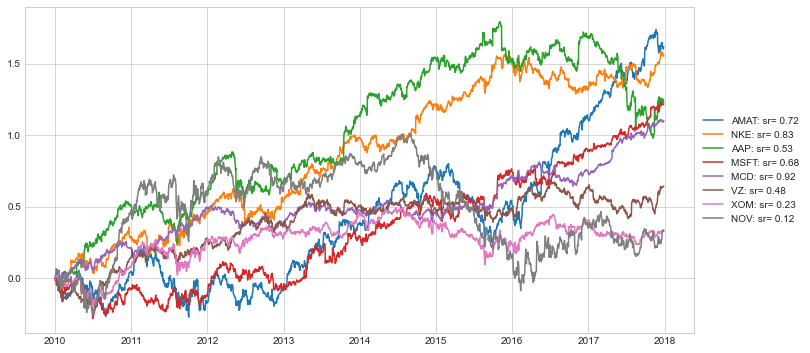

In [ ]:
line(returns_df, cumsum=True)

In [ ]:
transform_X = lambda x: x.rolling(12).mean().values
transform_y = lambda x: x.shift(-1).values

In [ ]:
features = transform_X(returns_df)
target = transform_y(returns_df)

In [ ]:
m = Backtester(estimator=MeanVariance(), ret=returns_df, start_date="2010-02-01", max_train_size=60)
m.train(features, target)

Backtester(estimator=MeanVariance(transform_V=<function MeanVariance.__init__.<locals>.<lambda> at 0x0000015EB70E1700>), start_date=2010-02-01, end_date=None)

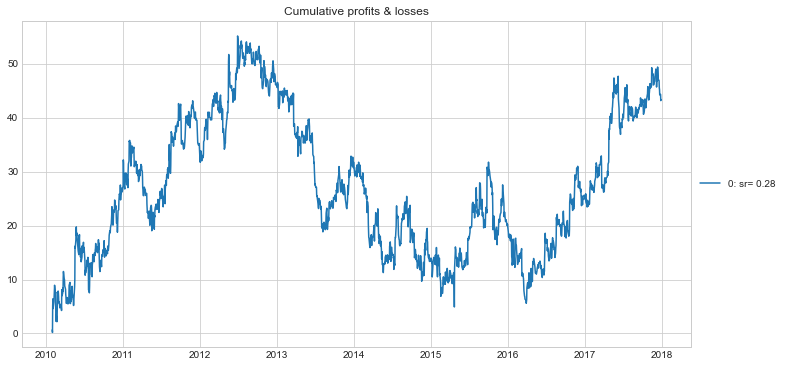

In [ ]:
pnl = m.pnl_

line(pnl, cumsum=True, start_date="2010-02-01", title="Cumulative profits & losses", figsize=(12, 6))

In [ ]:
pnls_ott = {}
for c in returns_df.columns:
    ret_ = returns_df.drop(c, axis=1)
    features_ = transform_X(ret_)
    target_ = transform_y(ret_)
    pnl_ = Backtester(estimator=MeanVariance(), ret=ret_, start_date="2010-02-01").train(features_, target_).pnl_
    pnls_ott[c] = pnl_.pipe(sharpe_ratio)

pnls_ott["ALL"] = pnl.pipe(sharpe_ratio)

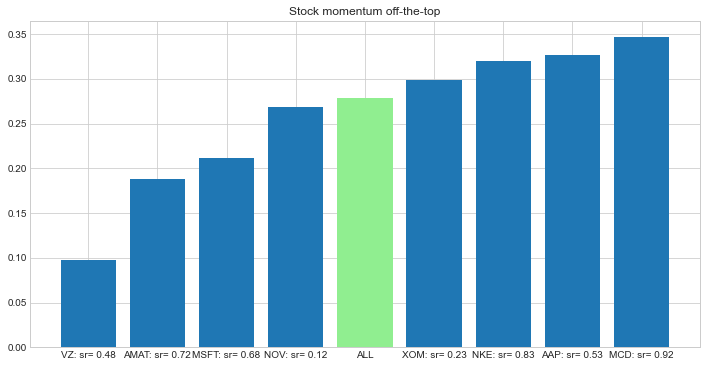

In [ ]:
bar(pnls_ott, baseline="ALL", title="Stock momentum off-the-top", figsize=(12, 6))

## `RRL`

In [83]:
rrl = RRL(n_assets=data.n_assets, n_features=data.n_features) 
rrl

RRL(n_assets=8, n_features=8, delta=0, rho=0.1, l2=0.01)

In [84]:
portfolio_returns, sharpe_ratios, cum_profits = [], [], []
batches = list(data.batches)

for ix in range(1, data.batches.ngroups, 2):

    (_, batch_train), (_, batch_val) = batches[ix-1], batches[ix]

    X_tr, r_tr = data.preprocess_batch(batch_train)
    
    if ix == 1: rrl.init_weights()

    train(rrl, X_tr, r_tr, tol=1e-4)
    
    X_val, r_val = data.preprocess_batch(batch_val)
    sr, cp = validation(rrl, X_val, r_val)

    print(f"Sharpe ratio on validation set: {sr}")
    print(f"Cumulative profits: {cp[-1]}")

    portfolio_returns.append(rrl.portfolio_returns)
    sharpe_ratios.append(sr)
    cum_profits.append(cp)

Training in progress...:  31%|███       | 31/100 [00:01<00:03, 21.91it/s, sharpe_ratio=0.338]


Sharpe ratio on validation set: 2.0894601115519698

Cumulative profits: 119.13408857987105

Training in progress...:  33%|███▎      | 33/100 [00:01<00:02, 24.52it/s, sharpe_ratio=2.03]


Sharpe ratio on validation set: 0.2391864054701092

Cumulative profits: 101.7062478429541

Training in progress...:  49%|████▉     | 49/100 [00:02<00:02, 21.27it/s, sharpe_ratio=0.456]


Sharpe ratio on validation set: -0.7823251763371937

Cumulative profits: 93.9321804767965

Training in progress...:  33%|███▎      | 33/100 [00:01<00:02, 24.17it/s, sharpe_ratio=0.958]


Sharpe ratio on validation set: 1.5363236145483554

Cumulative profits: 110.4528340882514

Training in progress...:  34%|███▍      | 34/100 [00:01<00:03, 20.58it/s, sharpe_ratio=0.361]


Sharpe ratio on validation set: 1.4217064254405205

Cumulative profits: 111.69862642801156

Training in progress...:  51%|█████     | 51/100 [00:02<00:02, 21.38it/s, sharpe_ratio=1.61]


Sharpe ratio on validation set: 0.4075458727304045

Cumulative profits: 102.2820275114849

Training in progress...:  75%|███████▌  | 75/100 [00:03<00:01, 21.92it/s, sharpe_ratio=-1.21]


Sharpe ratio on validation set: 0.039041649336997906

Cumulative profits: 100.0373332273129

Training in progress...:  25%|██▌       | 25/100 [00:01<00:03, 22.70it/s, sharpe_ratio=0.451]


Sharpe ratio on validation set: 0.22526976260820894

Cumulative profits: 101.73697335185048

Training in progress...:  95%|█████████▌| 95/100 [00:04<00:00, 22.90it/s, sharpe_ratio=0.342]


Sharpe ratio on validation set: 1.6762894048049326

Cumulative profits: 110.33363013489415

Training in progress...:   8%|▊         | 8/100 [00:00<00:04, 22.50it/s, sharpe_ratio=-.276]


Sharpe ratio on validation set: 2.847278028531727

Cumulative profits: 120.37428432749869

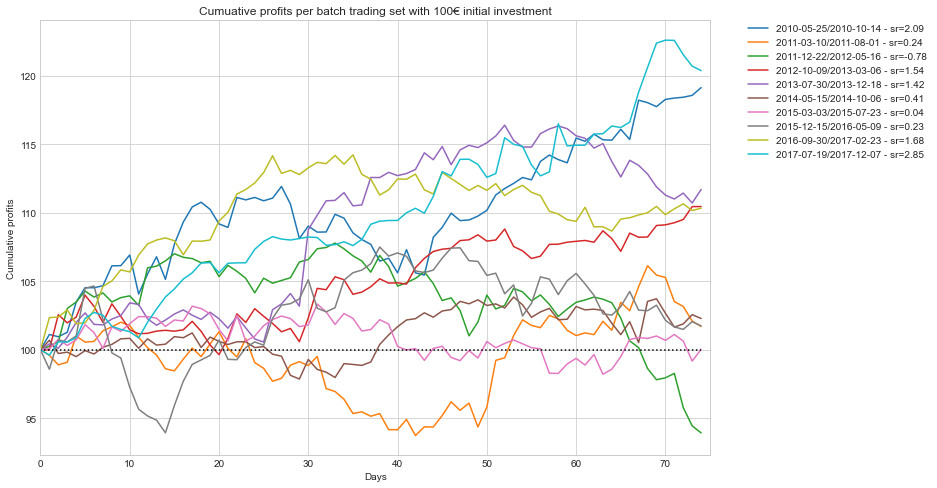

In [87]:
n_groups = len(cum_profits)
n_periods = cum_profits[0].shape[0]
initial_invest = 100

def get_batch_dates(batch_ix: int) -> str: 
    min_ = batches[2*batch_ix+1][1].index.min().strftime("%Y-%m-%d")
    max_ = batches[2*batch_ix+1][1].index.max().strftime("%Y-%m-%d")

    return f"{min_}/{max_}"

d = {
    f"{get_batch_dates(ix)} - sr={round(sr, 2)}": values 
    for sr, (ix, values) in zip(sharpe_ratios, enumerate(cum_profits))
}

df = pd.DataFrame(d).melt(var_name="Batch", value_name="Cumulative profits")
df["Days"] = np.array([[t for t in range(n_periods)] for _ in range(n_groups)]).reshape(n_groups*n_periods, 1)

fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(data=df, x="Days", y="Cumulative profits", hue="Batch", ax=ax)
sns.lineplot(
    x=[t for t in range(n_periods)], 
    y=[initial_invest for _ in range(n_periods)], 
    color="black", 
    linestyle="dotted")

ax.set_xlim((0, n_periods))

ax.set_title(f"Cumuative profits per batch trading set with {initial_invest}€ initial investment")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0); 